In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
best_network = load_model("best_network.h5")

2023-02-03 11:46:50.254413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 11:46:50.256129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [4]:
demo_dataset = image_dataset_from_directory(directory="./examples", shuffle=False, label_mode=None, image_size=(224, 224))

Found 6 files belonging to 1 classes.


2023-02-03 11:46:52.198653: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


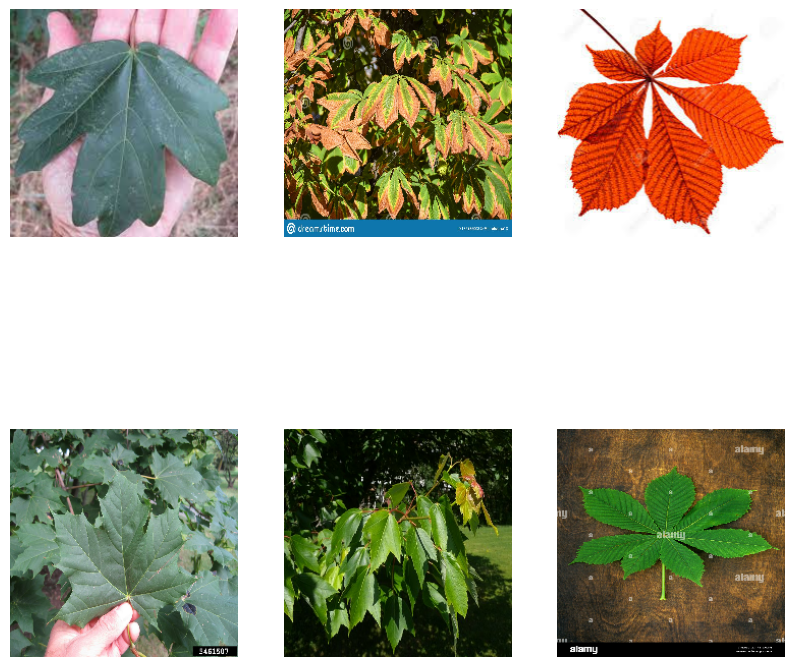

In [5]:
# Take a look at our 6 images 
plt.figure(figsize=(10, 10))
for batch in demo_dataset:
    for i, img in enumerate(batch):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.axis("off")

<h1>Make Predictions</h1>

In [6]:
# The network should predict [1, 0, 0, 1, 1, 0]
predictions = best_network.predict(demo_dataset)
predictions

2023-02-03 11:46:53.016209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 913ms/step


array([[1.0000000e+00],
       [7.3502835e-25],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

<h1>Analyse Predictions</h1>

In [7]:
# should be 1
round(predictions[0][0], 2)

1.0

This is perhaps one of the easier images to classify. I thought the slightly curved edges of the leaf might give the network a challenge, but the image is high quality and the network can clearly identify the leaf as maple.

In [13]:
# should be 0
round(predictions[1][0], 5)

0.0

<p>I thought the network might struggle here. The image contains discoloured horse chestnut leaves, so I think the network saw the reddish brown colour and settled on maple leaf. Although, I am surprised with how certain it is.</p>
<p>*Update*, I ran this again and it correctly identified the leaf as horse chestnut, so the network really does struggle here, seems to be 50/50 on which leaf it is. Therefore, I'm not sure why it only uses values that are almost exactly 1, or almost exactly 0.</p>

In [9]:
# should be 0
round(predictions[2][0], 2)

0.0

I thought this image would be a real test for the network. There are quite a lot of images of red maple leaves in the dataset, so I thought that might be a feature that the network would have learned. However, here I have given the network the image of a red horse chestnut leaf and it didn't fall into my trap so easily. So, the network seems to have learned to classify based on the shape of the leaves.

In [10]:
# should be 1
round(predictions[3][0], 2)

1.0

This is perhaps the easiest of the images in the example set, but I wanted to test if the network could pick out the leaf frm the human hand, as well as separate it from the rest of the green leaves behind it. It was able to fulfill it's duties quite easily.

In [11]:
# should be 1
round(predictions[4][0], 2)

0.0

<p>And we have our first failure, I am just surprised it was this one. Here's a list of my theories.</p>
<ol>
    <li>
        It could be that many of the images I collected for the horse chestnut leaves have a similar framing to this image, i.e. with the tree coming in from one side of the image and some grass/more of the tree to be seen in the background. But I don't think this is the likely cause.
    </li>
    <li>
        It could also be the opposite problem, in that many of the maple leaf pictures are just of a single leaf, held in the hand of someone, or nicely lit from the back by a white light. But again, I think the images I selected shouldn't lead to this being a problem.
    </li>
    <li>
        Maybe it is slightly related to both of these, and also similar to the image of the red horse chestnut leaf above. It could be that the network didn't learn that red means maple leaf, but instead learned that if the majority of the image is green, that means horse chestnut. The split of the images could also mean that every training set image was just of luscious green horse chestnut leaves, so the network learned that that means horse chestnut.
    </li>
</ol>
<p>I think number 3 is the most likely cause of the network failing here.</p>

In [12]:
# should be 0
round(predictions[5][0], 2)

0.0

We are back on track. I picked this image because it could be mistaken for a maple leaf if you drew a silhoutte, as the shape is similar. Regardless, I didn't think this image would be a major challenge.

<h1>Final Thoughts</h1>

<p>The one image that failed is a little bit puzzling, especially considering the network correctly identified the other images of horse chestnut which weren't majority green.</p>
<p>This leads me to believe that the network searches:
    <ul>
        <li>
            First for colour - if majority green, then can confidently say it is horse chestnut.
        </li>
        <li>
            Then if that fails, it will classify the images by searching for the shape of the leaves, in which case it is almost 100% accurate.
        </li>
    </ul>
</p>
<p>Clearly, this is a flawed approach, as maple trees also grow green leaves. This problem could have been avoided had the images been split in a different way. However, the easiest way to avoid this problem is to gather more examples.</p>
<p>Of course, these are just my thoughts, and example image 4 seems to be largely green but is correctly classified as maple, which contradicts my theory. Perhaps because the network can so easily identify the shape of the leaf, that overrode the majority green feature identifier.</p>
<p>Overall, this is an extremely accurate classifier of maple vs horse chestnut tree leaves, should anyone ever need that in their lives... but not 100% accurate... yet.</p>